In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, ZeroPadding2D,
                          MaxPooling2D, Activation, Dense, Dropout, Flatten)
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In [2]:
def vgg16(MODEL_NAME):
    x = Input(shape = (32, 32, 1))

    y = multiConvLayer(x, 64, 2) # size 32x32
    y = multiConvLayer(y, 128, 2) # size 16x16
    y = multiConvLayer(y, 256, 3) # size 8x8
    y = multiConvLayer(y, 512, 3) # size 4x4
    y = multiConvLayer(y, 512, 3) # size 2x2
    y = Flatten()(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 3)(y)
    y = Activation('softmax')(y)

    return Model(x, y, name = MODEL_NAME)

In [3]:
def vgg19(MODEL_NAME):
    x = Input(shape = (32, 32, 1))

    y = multiConvLayer(x, 64, 2) # size 32x32
    y = multiConvLayer(y, 128, 2) # size 16x16
    y = multiConvLayer(y, 256, 4) # size 8x8
    y = multiConvLayer(y, 512, 4) # size 4x4
    y = multiConvLayer(y, 512, 4) # size 2x2
    y = Flatten()(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 3)(y)
    y = Activation('softmax')(y)

    return Model(x, y, name = MODEL_NAME)

In [4]:
def multiConvLayer(x, value, n):
    y = x
    for _ in range(n):
        y = Conv2D(value, (3, 3), padding = 'same')(y)
        y = Activation('relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(y)
    return y

In [5]:
def checkDir(modelName):
    # Used to create all necessary folders
    # Not implemented yet
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Used to save the logs
    if not os.path.exists('logs'):
        os.makedirs('logs')
        
    # Used to save the logs
    if not os.path.exists('images'):
        os.makedirs('images')
        
    if not os.path.exists('models/'+modelName):
        os.makedirs('models/'+modelName)
        
    if not os.path.exists('images/'+modelName):
        os.makedirs('images/'+modelName)

In [23]:
def load_dataset():
    x_train = np.load("trainX.npy")
    x_test = np.load("testX.npy")
    x_val = np.load("valX.npy")
    
    y_train = np.load("trainY.npy")
    y_test = np.load("testY.npy")
    y_val = np.load("valY.npy")
    
    x_train = x_train.reshape(-1, 32, 32, 1)
    x_test = x_test.reshape(-1, 32, 32, 1)
    x_val = x_val.reshape(-1, 32, 32, 1)
    
    #y_train = to_categorical(y_train) # encode one-hot vector
    #y_test = to_categorical(y_test)
    #y_val = to_categorical(y_val)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [7]:
def save_model(model, modelName):
    # serialize model to JSON
    model_json = model.to_json()
    with open("models/" + modelName + "/model.json", "w") as json_file:
        json_file.write(model_json)
        
    # Save the model with best accuracy as final model
    mylist = os.listdir('models/'+modelName)
    if os.path.exists('models/' + modelName + '/' + 'model.h5'):
        os.remove('models/' + modelName + '/' + 'model.h5')
    os.rename('models/' + modelName + '/' +mylist[len(mylist)-1],'models/' + modelName + '/' + 'model.h5')
    
    mylist.remove(mylist[len(mylist)-1])
    
    while len(mylist) > 2:
        os.remove('models/' + modelName + '/' + mylist[len(mylist)-1])
        mylist.remove(mylist[len(mylist)-1])

    print("Saved model to disk")

In [8]:
def load_model(modelName):
    
    if os.path.isfile('models/' + modelName + '/model.json') and os.path.isfile('models/' + modelName + '/model.h5'):
        # Load json and create model
        json_file = open('models/' + modelName + '/model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        
        # Load weights into new model
        loaded_model.load_weights('models/' + modelName + '/model.h5')

        print("Loaded model from disk")
    else:
        print ("Model does not exist. Train it first!")
    

    return loaded_model

In [9]:
def generatePlots(history, model, test_data, modelName):
    # Generate Training/Validation plots
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_graph = range(1, len(acc) + 1)

    plt.figure()
    plt.title('Training and Validation Accuracy', fontsize = '24')
    plt.xlabel("Epochs", fontsize = '24')
    plt.ylabel("Accuracy", fontsize = '24')
    plt.xticks(fontsize = '20')
    plt.yticks(fontsize = '20')
    plt.plot(epochs_graph, acc, 'red', label='Training accuracy')
    plt.plot(epochs_graph, val_acc, 'blue', label='Validation accuracy')
    plt.legend()

    plt.savefig('images/'+ modelName + '/TrainingAndValidationAcc_' + modelName + '.png')

    plt.figure()
    plt.title('Training and Validation Loss', fontsize = '24')
    plt.xticks(fontsize = '20')
    plt.yticks(fontsize = '20')
    plt.xlabel("Epochs", fontsize = '24')
    plt.ylabel("Loss", fontsize = '24')
    plt.plot(epochs_graph, loss, 'red', label='Training loss')
    plt.plot(epochs_graph, val_loss, 'blue', label='Validation loss')
    plt.legend()

    plt.savefig('images/'+ modelName + '/TrainingAndValidationLoss_' + modelName + '.png')
    plt.show()

    Y_pred = model.predict(test_data[0])
    Y_pred_classes = np.argmax(Y_pred, axis = 1) 
    Y_truth = np.argmax(test_data[1], axis = 1) 

    confusion_mtx = confusion_matrix(Y_truth, Y_pred_classes)

    f, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="viridis", linecolor="gray", fmt= '.1f', ax = ax)
    plt.xlabel("Predicted Label", fontsize = 24)
    plt.ylabel("True Label", fontsize = 24)
    plt.xticks(fontsize = '20')
    plt.yticks(fontsize = '20')
    plt.title("Confusion Matrix", fontsize = '24')

    plt.savefig('images/'+ modelName + '/ConfusionMatrix_' + modelName + '.png')
    plt.show()

In [10]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors, x, y, nrows, ncols):
    n = 0
    nrows = nrows
    ncols = ncols
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((x, y)),  cmap = "gray")
            ax[row, col].set_title("Predicted label: {}\nTrue label: {}".format(pred_errors[error], obs_errors[error]))
            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])
            ax[row, col].set_xticklabels([])
            ax[row, col].set_yticklabels([])
            n += 1

In [11]:
def badPredictions(model, testData):
    Y_pred = model.predict(testData[0])
    Y_pred_classes = np.argmax(Y_pred, axis = 1) 
    Y_truth = np.argmax(testData[1], axis = 1) 
    
    np.sum(Y_truth == Y_pred_classes) / len(Y_truth)
    
    errors = (Y_pred_classes - Y_truth != 0)

    Y_pred_classes_errors = Y_pred_classes[errors]
    Y_pred_errors = Y_pred[errors]
    Y_true_errors = Y_truth[errors]
    X_test_errors = testData[0][errors]


    Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1)
    True_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
    Delta_pred_true_errors = Y_pred_errors_prob - True_prob_errors
    Sorted_dela_errors = np.argsort(Delta_pred_true_errors)
    Most_important_errors = Sorted_dela_errors[-16:]
    
    display_errors(Most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors, 32, 32, 4, 4)

In [12]:
def main(arg):
    # Define Adam Optimizer
    adam = Adam(lr=1e-4, decay=1e-6)
    
    tensorboard = TensorBoard(write_grads=True, write_images=True)
    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
       
    if arg == "vgg16-train":
        
        MODEL_NAME = "VGG16"
        
        # Load dataset
        training_data, val_data, test_data = load_dataset()
        
        # Create directories
        checkDir(MODEL_NAME)
        
        # Save best model based on validation accuracy
        chkpoint = ModelCheckpoint("models/" + MODEL_NAME +"/weights.{epoch:02d}-{val_accuracy:.4f}.hdf5", save_best_only=True, monitor='val_accuracy', mode='max')
        
        # Create the model architecture
        model = vgg16(MODEL_NAME)
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

        datagen.fit(training_data[0])

        batch_size = 25
        history = model.fit(datagen.flow(training_data[0], training_data[1], batch_size = batch_size), epochs=50, validation_data=(val_data[0], val_data[1]), steps_per_epoch = training_data[0].shape[0] // batch_size, callbacks = [tensorboard, chkpoint])

        generatePlots(history, model, test_data, MODEL_NAME)
        save_model(model, MODEL_NAME)
        
    elif arg == "vgg19-train":
        
        MODEL_NAME = "VGG19"
        
        # Load dataset
        training_data, val_data, test_data = load_dataset()
        
        # Create directories
        checkDir(MODEL_NAME)
        
        # Save best model based on validation accuracy
        chkpoint = ModelCheckpoint("models/" + MODEL_NAME +"/weights.{epoch:02d}-{val_accuracy:.4f}.hdf5", save_best_only=True, monitor='val_accuracy', mode='max')
        
        # Create the model architecture
        model = vgg19(MODEL_NAME)
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

        datagen.fit(training_data[0])

        batch_size = 25
        history = model.fit(datagen.flow(training_data[0], training_data[1], batch_size = batch_size), epochs=50, validation_data=(val_data[0], val_data[1]), steps_per_epoch = training_data[0].shape[0] // batch_size, callbacks = [tensorboard, chkpoint])

        generatePlots(history, model, test_data, MODEL_NAME)
        save_model(model, MODEL_NAME)
        

        
    elif arg == "test-vgg16":
        
        MODEL_NAME = "VGG16"
        
        # Load the model
        model = load_model(MODEL_NAME)
        
        # Load dataset
        training_data, val_data, test_data = load_dataset()
        
        # Compile the model
        model.compile(adam, 'sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Get score
        score = model.evaluate(test_data[0], test_data[1], verbose=0)
        print(score)
        
        badPredictions(model, test_data)
        

        
    elif arg == "test-vgg19":
        
        MODEL_NAME = "VGG19"
        
        # Load the model
        model = load_model(MODEL_NAME)
        
        # Load dataset
        training_data, val_data, test_data = load_dataset()
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])
        
        # Get score
        score = model.evaluate(test_data[0], test_data[1], verbose=0)
        print(score)
        
        badPredictions(model, test_data)
        
    else:
        print("Invalid argument")
        sys.exit()

  ...
    to  
  ['...']
Train for 3807 steps, validate on 20399 samples
Epoch 1/50
3807/3807 [==============================] - 129s 34ms/step - loss: 0.9296 - accuracy: 0.4818 - val_loss: 0.8720 - val_accuracy: 0.5416
Epoch 2/50
3807/3807 [==============================] - 128s 34ms/step - loss: 0.7627 - accuracy: 0.6188 - val_loss: 0.5660 - val_accuracy: 0.7424
Epoch 3/50
3807/3807 [==============================] - 126s 33ms/step - loss: 0.4717 - accuracy: 0.7954 - val_loss: 0.3027 - val_accuracy: 0.8785
Epoch 4/50
3807/3807 [==============================] - 128s 34ms/step - loss: 0.2711 - accuracy: 0.8926 - val_loss: 0.1670 - val_accuracy: 0.9380
Epoch 5/50
3807/3807 [==============================] - 123s 32ms/step - loss: 0.1803 - accuracy: 0.9324 - val_loss: 0.1185 - val_accuracy: 0.9580
Epoch 6/50
3807/3807 [==============================] - 123s 32ms/step - loss: 0.1341 - accuracy: 0.9510 - val_loss: 0.1053 - val_accuracy: 0.9618
Epoch 7/50
3807/3807 [=======================

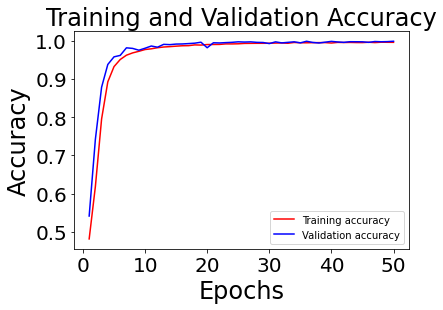

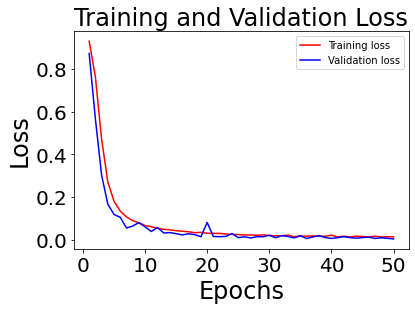

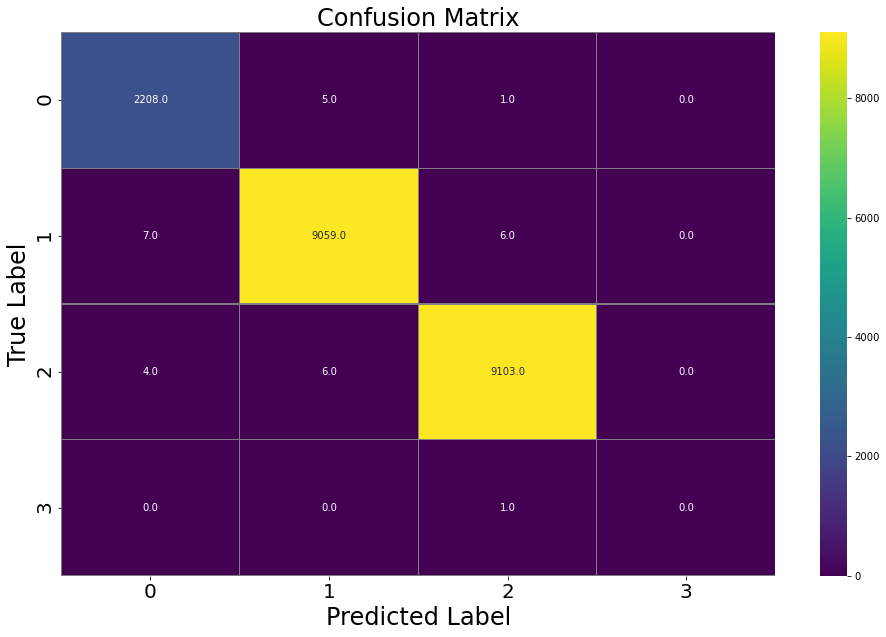

Saved model to disk


In [13]:
# Train VGG16
main("vgg16-train")

In [24]:
# Test VGG16
main("test-vgg16")

Loaded model from disk


ValueError: You are passing a target array of shape (20400, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

  ...
    to  
  ['...']
Train for 3807 steps, validate on 20399 samples
Epoch 1/50
3807/3807 [==============================] - 156s 41ms/step - loss: 0.9552 - accuracy: 0.4518 - val_loss: 0.9329 - val_accuracy: 0.4786
Epoch 2/50
3807/3807 [==============================] - 153s 40ms/step - loss: 0.9073 - accuracy: 0.5022 - val_loss: 0.8301 - val_accuracy: 0.5695
Epoch 3/50
3807/3807 [==============================] - 153s 40ms/step - loss: 0.7493 - accuracy: 0.6336 - val_loss: 0.6484 - val_accuracy: 0.6991
Epoch 4/50
3807/3807 [==============================] - 154s 40ms/step - loss: 0.4776 - accuracy: 0.7962 - val_loss: 0.3177 - val_accuracy: 0.8697
Epoch 5/50
3807/3807 [==============================] - 153s 40ms/step - loss: 0.2686 - accuracy: 0.8953 - val_loss: 0.1682 - val_accuracy: 0.9381
Epoch 6/50
3807/3807 [==============================] - 153s 40ms/step - loss: 0.1758 - accuracy: 0.9348 - val_loss: 0.1156 - val_accuracy: 0.9576
Epoch 7/50
3807/3807 [=======================

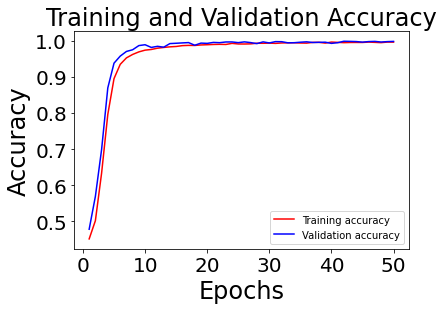

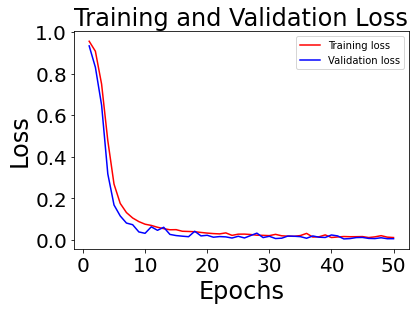

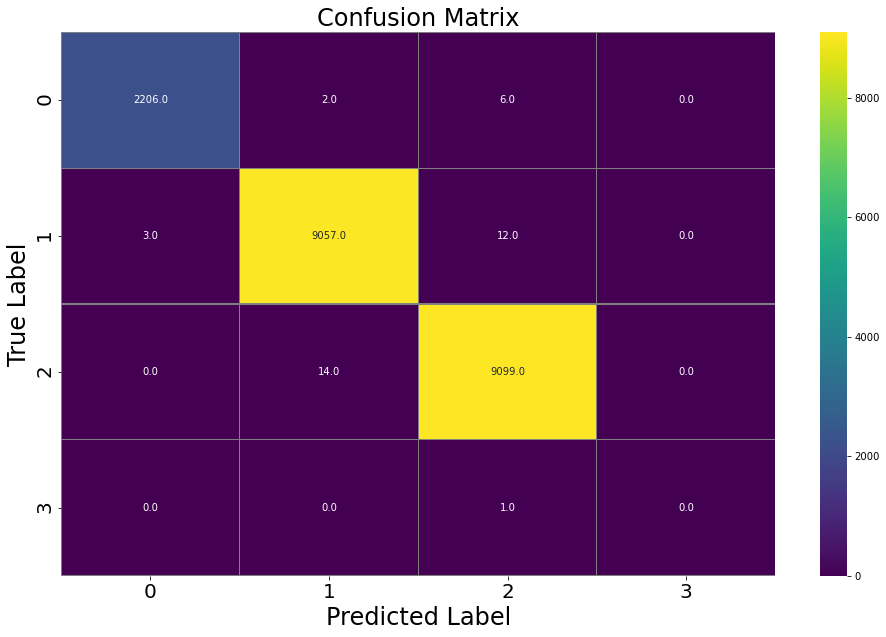

Saved model to disk


In [13]:
# Train VGG19 
main("vgg19-train")

In [ ]:
# Test VGG19 
main("test-vgg19")

ERROR! Session/line number was not unique in database. History logging moved to new session 234


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Loaded model from disk
Traceback (most recent call last):
  File "C:\Users\Roger\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-c9c40b750665>", line 2, in <module>
    main("test-vgg19")
  File "<ipython-input-12-a3f1e09ddb6b>", line 111, in main
    score = model.evaluate(test_data[0], test_data[1], verbose=0)
  File "C:\Users\Roger\anaconda3\envs\ml\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 930, in evaluate
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\Roger\anaconda3\envs\ml\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 490, in evaluate
    use_multiprocessing=use_multiprocessing, **kwargs)
  File "C:\Users\Roger\anaconda3\envs\ml\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 426, in _model_iteration
    use_multiprocessing=use_multiprocessing)
  File "